# **Human Activity Recognition with smartphone database**

## [**Outline:**]()

- Project objective
- Import libraries
- Read the data as a dataframe
- Data Preprocessing including handling missing values, outliers, and converting data into a suitable format for machine learning algorithms.
-Feature Engineering that is selecting and transforming the relevant features from the dataset.


## [**Project objective:**]()

The objective of this project is to identify various activities, including walking, walking upstairs, walking downstairs, sitting, standing, and lying, using data collected from the smartphones carried by the study participants during their daily activities. These smartphones are equipped with an embedded inertial sensor that measures both acceleration and angular velocity along three mutually perpendicular axes.

The data collected includes:

 I. Triaxial acceleration from the accelerometer comprising both total acceleration and estimated body acceleration.<br>
 II. Triaxial Angular velocity from the gyroscope.<br>
 III. A 561-feature vector containing time and frequency domain variables.<br>
 IV. Activity label.<br>

## [**Import libraries**]()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
pd.set_option('Display.max_rows', None, 'Display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
sns.set_style('dark')
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_score
from sklearn.metrics import recall_score, accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score

from sklearn.model_selection import GridSearchCV,  RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

import os
from scipy import stats
import pickle
import time

In [ ]:
def folder_locator(folder_name):
  """
  This function returns the path of the given folder
  """
  path_name = None

  for dir, folders, files in os.walk(os.getcwd()):
    if folder_name in folders:
      path_name = os.path.join(dir, folder_name)
      break
  return path_name

In [ ]:
folder_name = 'Activity_recognition_github_version'
path_name = folder_locator(folder_name)

The path_name will be used later for saving the data after cleaning and preprocessing.

## [**Read the data as a dataframe**]()

In [ ]:
data_file = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/Human_Activity_Recognition_Using_Smartphones_Data.csv"

na_identifiers = ['?', 'NaN', 'nan', 'N/A', 'n/a', 'unknown', 'Unknown']

df = pd.read_csv(data_file, sep=',', na_values=na_identifiers)

In [ ]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 44.2+ MB


## [**Data cleaning and preprocessing**]()

### **Identifying missing values if there is any.**

In [ ]:
if ~df.isnull().sum().any():
  print("Data has no missing values.")
else:
 print("Data contains missing values!")

Data has no missing values.


### **Identifying duplicate rows if there is any.**

In [ ]:
if ~df.duplicated().sum().any():
  print("Data has no duplicate rows.")
else:
 print("Data contains duplicate rows!")

Data has no duplicate rows.


### **Identifying categorical, discrete and continuous variables**

In [ ]:
df.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [ ]:
df.dtypes[df.dtypes==object]

Activity    object
dtype: object

There is only one categorical column in the data and that is the output variable i.e. `Activity`.

In [ ]:
target_label = 'Activity'

In [ ]:
discrete_columns = [col for col in df.columns if (df[col].dtype!=object) and (df[col].nunique()<=20)]
len(discrete_columns)

0

Therefore all features are continuous

In [ ]:
features = df.drop(target_label, axis=1).columns

### **Target variable characteristics**

In [ ]:
df[target_label].describe()

count      10299
unique         6
top       LAYING
freq        1944
Name: Activity, dtype: object

In [ ]:
activity_dist = round(df[target_label].value_counts(normalize=True)*100,2).to_frame()

activity_dist.columns=[f'{target_label} distribution in the data(%)']

display(activity_dist)

,Activity distribution in the data(%)
LAYING,18.88
STANDING,18.51
SITTING,17.25
WALKING,16.72
WALKING_UPSTAIRS,14.99
WALKING_DOWNSTAIRS,13.65


The target variable (activity labels) is the only categorical variable in the current data and consists of six distinct activities. Although the most frequent activity is Laying, activities distributions in the data is fairly balanced.

### **Convert target variable to a numeric variable.**

Scikit learn classifiers won't accept string values as input.
Thus, the output labels should be converted to integers. For this purpose here LabelEncoder is used.

In [ ]:
le = LabelEncoder()
df[target_label] = le.fit_transform(df[target_label])

In [ ]:
target_column_dict = dict(zip(le.transform(le.classes_),le.classes_))
print(target_column_dict)

{0: 'LAYING', 1: 'SITTING', 2: 'STANDING', 3: 'WALKING', 4: 'WALKING_DOWNSTAIRS', 5: 'WALKING_UPSTAIRS'}


In [ ]:
activity_dist = round(df[target_label].value_counts(normalize=True)*100,2).to_frame()
activity_dist['Activity labels'] = activity_dist.index.map(target_column_dict)
activity_dist.columns=['Activity distribution in the data(%)', 'Activity labels']
display(activity_dist.sort_index())

,Activity distribution in the data(%),Activity labels
0,18.88,LAYING
1,17.25,SITTING
2,18.51,STANDING
3,16.72,WALKING
4,13.65,WALKING_DOWNSTAIRS
5,14.99,WALKING_UPSTAIRS


### **Features characteristics**

**Range of features values**

**Minimum values**

In [ ]:
df[features].min().value_counts()

-1.0    561
dtype: int64

**Maximum values**

In [ ]:
df[features].max().value_counts()

1.0    561
dtype: int64

## [**Feature selection**]()

In [ ]:
cor = df[features].corr()

cor_lower_index = np.tril_indices_from(cor)

for i in zip(*cor_lower_index):
    cor.iloc[i[0], i[1]] = np.NaN

# Stack the data and convert to a data frame
cor = (cor.stack().to_frame().reset_index().rename(columns={'level_0':'feature1',
                                                            'level_1':'feature2',
                                                            0:'correlation'}))

# Get the absolute values for sorting
cor['abs_correlation'] = cor['correlation'].abs()

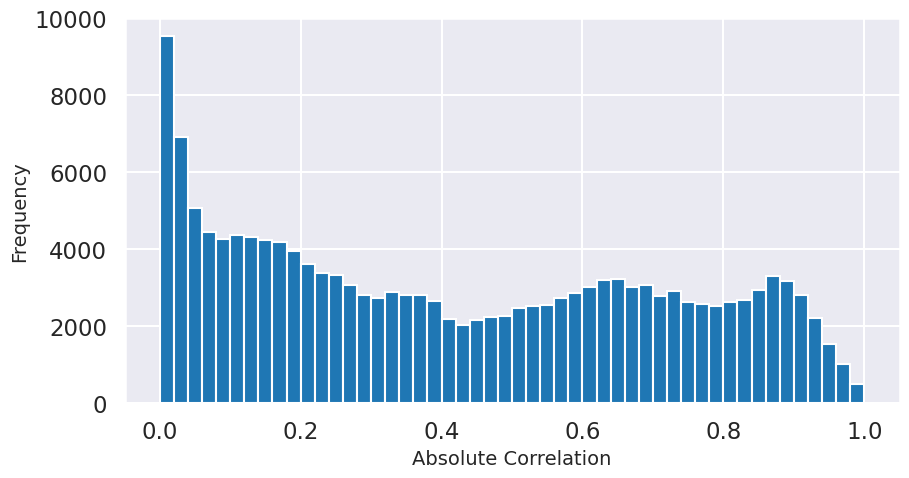

In [ ]:
plt.figure()
cor['abs_correlation'].hist(bins=50, figsize=(10, 5))
plt.xlabel('Absolute Correlation', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [ ]:
# The most highly correlated values
d=cor.sort_values('correlation', ascending=False).query('abs_correlation>=0.8')
#ax=d['abs_correlation'].hist(bins=50, figsize=(12, 8))
#ax.set(xlabel='Absolute Correlation', ylabel='Frequency')
display(d)

In [ ]:
d.columns

Index(['feature1', 'feature2', 'correlation', 'abs_correlation'], dtype='object')

In [ ]:
len(d[d['feature1']!=d['feature2']]) == len(d)

True

In [ ]:
selected_features = set(features) - set(d['feature2'])
selected_features = list(selected_features)

In [ ]:
print(f""" Among {len(features)} features, {len(set(d['feature2']))} features were redundant and
were dropped(0.8 or greater correlation).
Therefor, length of the selected features = {len(selected_features)}""")

 Among 561 features, 417 features were redundant and
were dropped(0.8 or greater correlation). 
Therefor, length of the selected features = 144


Redundant features can indeed cause overfitting, increase computational complexity, and present challenges in model interpretability. They can also lead to multicollinearity issues, making it difficult for the model to distinguish the individual contributions of highly correlated features and potentially resulting in unstable coefficient estimates.

In [ ]:
df[selected_features].describe()

,"tBodyAccJerk-arCoeff()-Z,4",tBodyAccJerk-mean()-Y,"angle(tBodyGyroJerkMean,gravityMean)",tBodyAccJerk-mean()-Z,"tBodyAcc-correlation()-Y,Z","angle(tBodyAccJerkMean),gravityMean)",tGravityAcc-entropy()-X,tBodyAcc-mean()-Z,tBodyGyroJerk-mean()-Y,"angle(tBodyAccMean,gravity)","tBodyAccJerk-arCoeff()-Y,3",fBodyGyro-meanFreq()-Y,fBodyAccJerk-maxInds-X,tBodyAccJerk-mean()-X,"tGravityAcc-correlation()-X,Y",fBodyAcc-skewness()-X,"tBodyGyro-arCoeff()-X,3","angle(tBodyGyroMean,gravityMean)","tBodyGyroJerk-correlation()-X,Y",fBodyBodyGyroJerkMag-maxInds,tBodyGyroJerkMag-arCoeff()3,"tBodyAccJerk-arCoeff()-X,3",tBodyAcc-mean()-X,"fBodyAccJerk-bandsEnergy()-57,64.1","tBodyGyro-arCoeff()-Y,1",tBodyGyro-entropy()-X,"tBodyGyroJerk-correlation()-X,Z",tBodyGyroJerkMag-arCoeff()2,"tBodyGyro-arCoeff()-X,1",fBodyAcc-min()-Z,"tBodyAccJerk-arCoeff()-X,2",tBodyAcc-std()-X,"tGravityAcc-correlation()-X,Z","tBodyAccJerk-arCoeff()-Y,4",fBodyAcc-min()-X,"tBodyAcc-arCoeff()-Z,1",tBodyGyroMag-arCoeff()1,fBodyBodyGyroMag-maxInds,tGravityAcc-std()-Y,tGravityAcc-entropy()-Z,fBodyBodyGyroJerkMag-meanFreq(),fBodyAccMag-skewness(),"tBodyGyro-arCoeff()-Y,4","tBodyGyroJerk-arCoeff()-Z,4",tGravityAcc-mean()-Y,fBodyAcc-skewness()-Z,fBodyGyro-min()-X,"tBodyAccJerk-correlation()-X,Z",fBodyAcc-maxInds-X,"tBodyGyroJerk-arCoeff()-X,2","tBodyGyro-correlation()-X,Z",fBodyBodyGyroMag-skewness(),"tBodyGyroJerk-arCoeff()-X,4","tBodyAccJerk-correlation()-Y,Z","tBodyGyroJerk-arCoeff()-Z,3",tBodyAccMag-arCoeff()3,fBodyAcc-meanFreq()-Z,tBodyGyro-entropy()-Y,fBodyAccMag-meanFreq(),fBodyAccJerk-maxInds-Z,fBodyGyro-min()-Z,fBodyGyro-min()-Y,"tGravityAcc-correlation()-Y,Z","fBodyAccJerk-bandsEnergy()-57,64.2","tBodyGyro-correlation()-X,Y","tBodyGyroJerk-arCoeff()-Y,4",fBodyGyro-meanFreq()-X,tBodyAccJerkMag-arCoeff()4,fBodyGyro-skewness()-X,fBodyBodyAccJerkMag-skewness(),fBodyAcc-meanFreq()-X,"tBodyAcc-correlation()-X,Y",fBodyAcc-meanFreq()-Y,fBodyGyro-meanFreq()-Z,fBodyBodyAccJerkMag-min(),tGravityAcc-entropy()-Y,tBodyGyroMag-arCoeff()3,"tBodyAcc-arCoeff()-Z,4","tBodyAccJerk-arCoeff()-Z,2",tBodyAcc-mean()-Y,fBodyAcc-min()-Y,fBodyAccJerk-min()-Y,"tBodyAcc-arCoeff()-Y,3",tGravityAcc-sma(),tBodyGyroJerkMag-arCoeff()1,tGravityAcc-energy()-Z,fBodyGyro-skewness()-Z,tGravityAcc-mean()-Z,fBodyBodyGyroJerkMag-skewness(),"fBodyGyro-bandsEnergy()-57,64.1","tBodyAccJerk-correlation()-X,Y",fBodyAccJerk-min()-X,fBodyAccJerk-skewness()-Z,tBodyGyroMag-entropy(),tBodyAccMag-arCoeff()1,tGravityAcc-std()-X,"tBodyGyro-arCoeff()-Z,4","tBodyAcc-arCoeff()-X,1","tBodyAccJerk-arCoeff()-Z,3",fBodyAcc-skewness()-Y,"fBodyAcc-bandsEnergy()-57,64.2",fBodyGyro-maxInds-X,tBodyAccJerkMag-arCoeff()3,"tGravityAcc-arCoeff()-Y,1",fBodyAcc-maxInds-Z,fBodyGyro-skewness()-Y,"tBodyGyroJerk-arCoeff()-Y,2","tBodyAccJerk-arCoeff()-X,4","tBodyAcc-correlation()-X,Z",fBodyAcc-maxInds-Y,"tBodyGyro-arCoeff()-X,4","tBodyAcc-arCoeff()-Z,3",fBodyAccJerk-min()-Z,"tBodyGyro-correlation()-Y,Z",tBodyGyroJerk-mean()-X,tGravityAcc-mean()-X,"tBodyAcc-arCoeff()-Y,4","fBodyAccJerk-bandsEnergy()-57,64",tGravityAcc-std()-Z,"tBodyGyro-arCoeff()-Z,1",fBodyAccMag-min(),fBodyAccJerk-skewness()-X,fBodyGyro-maxInds-Z,"tBodyGyroJerk-correlation()-Y,Z",tBodyGyro-mean()-Z,fBodyAccJerk-maxInds-Y,tBodyGyro-mean()-X,fBodyBodyAccJerkMag-meanFreq(),"tBodyGyro-arCoeff()-Y,3","tGravityAcc-arCoeff()-Z,1","tBodyGyroJerk-arCoeff()-X,3",fBodyAccJerk-skewness()-Y,fBodyAccMag-maxInds,fBodyGyro-maxInds-Y,"tBodyAcc-arCoeff()-X,4",tBodyGyroJerkMag-arCoeff()4,tBodyGyro-entropy()-Z,"tBodyAcc-arCoeff()-Y,1",tBodyAccJerkMag-arCoeff()1,fBodyBodyGyroMag-min(),"tGravityAcc-arCoeff()-X,1",fBodyBodyAccJerkMag-maxInds,tBodyGyro-mean()-Y,tBodyGyroJerk-mean()-Z
count,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.00

In [ ]:
data_daily_activity = {}
data_daily_activity['description'] = """
This file contains the cleaned data, list of all features,
list of selected features, target column data and label
and target classes dictionary.
"""
data_daily_activity['target_label'] = target_label
data_daily_activity['target_data'] = df[target_label]
data_daily_activity['target_classes_dictionary'] = target_column_dict
data_daily_activity['activity_distribution'] = activity_dist
data_daily_activity['selected_features'] = selected_features
data_daily_activity['all_features'] = features
data_daily_activity['cleaned_data'] = df[features]

## [**Save the final version of data**]()

In [ ]:
filename = os.path.join(path_name,'data_daily_activity.sav')
pickle.dump(data_daily_activity, open(filename, 'wb'))

## [**Machine learning**]()

### **Split the data into train and test data sets**


In [ ]:
filename = os.path.join(path_name,'data_daily_activity.sav')
data = pickle.load(open(filename, 'rb'))
data.keys()

dict_keys(['description', 'target_label', 'target_data', 'target_classes_dictionary', 'activity_distribution', 'selected_features', 'all_features', 'cleaned_data'])

In [ ]:
X = data['cleaned_data']
X = X[data['selected_features']]
y = data['target_data']

In [ ]:
np.round(y.value_counts(normalize=True)*100,2)

0    18.88
2    18.51
1    17.25
3    16.72
5    14.99
4    13.65
Name: Activity, dtype: float64

In [ ]:
data['activity_distribution']

,Activity distribution in the data(%),Activity labels
0,18.88,LAYING
1,17.25,SITTING
2,18.51,STANDING
3,16.72,WALKING
4,13.65,WALKING_DOWNSTAIRS
5,14.99,WALKING_UPSTAIRS


In [ ]:
X.shape[1] == len(data['selected_features'])

True

In [ ]:
x_train, x_test, y_train,y_test = train_test_split(X,y,test_size=0.3,
                                                   stratify=y,
                                                   random_state=0,
                                                   shuffle=True)

In [ ]:
t = pd.concat([y.value_counts(normalize=True)*100,
           y_train.value_counts(normalize=True)*100,
           y_test.value_counts(normalize=True)*100], axis=1)

t.columns = ['Activity y', 'Activity y_train', 'Activity y_test']
t.sort_index(inplace=True)
t.index = data['target_classes_dictionary'].values()
t = round(t,2)
display(t)

,Activity y,Activity y_train,Activity y_test
LAYING,18.88,18.88,18.87
SITTING,17.25,17.26,17.25
STANDING,18.51,18.50,18.51
WALKING,16.72,16.72,16.73
WALKING_DOWNSTAIRS,13.65,13.65,13.66
WALKING_UPSTAIRS,14.99,15.00,14.98


By stratifying the split, the ratios of output classes are preserved.

### **Model fitting**


#### **1. Logistic regression with liblinear solver and default parameters**

In [ ]:
# Standard logistic regression
lr = LogisticRegression(solver='liblinear',random_state=0)

# 'liblinear' applies one vs. others method to classify the output
print("simple logistic regression parameters with liblinear solver")
for i in ['C', 'max_iter','penalty']:
  print(f'{i}:{lr.get_params()[i]}')

simple logistic regression parameters with liblinear solver
C:1.0
max_iter:100
penalty:l2


In [ ]:
start_time = time.time()

lr.fit(x_train, y_train)

end_time = time.time()
## Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time:.2f} seconds")

Training time: 1.28 seconds


In [ ]:
#import time
#from tqdm import tqdm

#start_time = time.time()
#progress_bar = tqdm(total=len(x_train), unit="samples")

## Training loop
#for i in range(len(x_train)):
#    lr.fit(x_train[i:i+1], y_train[i:i+1])
#    progress_bar.update(1)

#end_time = time.time()

#progress_bar.close()

## Calculate the elapsed time
#elapsed_time = end_time - start_time

#print(f"Training time: {elapsed_time:.2f} seconds")

#### **2. Logistic regression with liblinear solver and L1 (Lasso) regularization method along with Hypertunning regularization parameter C**

In [ ]:
parameters = {'penalty':['l1'],
              'C':np.linspace(0.5,100,100)}

estimator = LogisticRegression(solver='liblinear')

scoring = {
    'accuracy': 'accuracy',
    'precision_micro': 'precision_micro',
    'recall_micro': 'recall_micro',
    'f1_micro': 'f1_micro',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro',
    'f1_macro': 'f1_macro',
}

refit_metric = 'accuracy'

cv = StratifiedKFold(n_splits=5,
                     shuffle=True,
                     random_state=1)

#lrl1 = GridSearchCV(estimator = estimator,
#                        param_grid=parameters,
#                        scoring=scoring,
#                        refit = refit_metric,
#                        cv = cv,
#                        return_train_score=True,
#                       verbose=0)

lrl1 = RandomizedSearchCV(estimator = estimator,
                              param_distributions=parameters,
                              n_iter=10,
                              scoring=scoring,
                              refit = refit_metric,
                              return_train_score=True,
                              n_jobs=-1,
                              cv=cv,
                              random_state=1,)

#lrl1.get_params

In [ ]:
start_time = time.time()

lrl1.fit(x_train,y_train)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time:.2f} seconds")

Training time: 1247.22 seconds


#### **3. Logistic regression with liblinear solver and L2 (Ridge) regularization method along with Hypertunning regularization parameter C**

In [ ]:
parameters = {'penalty':['l2'],
              'C':np.linspace(0.5,100,100)}

lrl2 = RandomizedSearchCV(estimator = estimator,
                          param_distributions=parameters,
                          n_iter=10,
                          scoring=scoring,
                          refit = refit_metric,
                          return_train_score=True,
                          n_jobs=-1,
                          cv=cv,
                          random_state=1,)

In [ ]:
start_time = time.time()

lrl2.fit(x_train,y_train)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time:.2f} seconds")

Training time: 95.17 seconds


In [ ]:
model_dict = {'lr':lr, 'lrl1':lrl1, 'lrl2':lrl2}


### **Save the cleaned data, models and parameters**

In [ ]:
filename = os.path.join(path_name,'fitted_models.sav')
pickle.dump(model_dict, open(filename, 'wb'))

In [ ]:
xtrain_file = os.path.join(path_name,'X_train.csv')
x_train.to_csv(xtrain_file, index=False)

xtest_file = os.path.join(path_name,'X_test.csv')
x_test.to_csv(xtest_file, index=False)

ytrain_file = os.path.join(path_name,'y_train.csv')
y_train.to_csv(ytrain_file, index=False)

ytest_file = os.path.join(path_name,'y_test.csv')
y_test.to_csv(ytest_file, index=False)

### **Load the models**

In [ ]:
xtrain_file = os.path.join(path_name,'X_train.csv')
x_train = pd.read_csv(xtrain_file)

xtest_file = os.path.join(path_name,'X_test.csv')
x_test = pd.read_csv(xtest_file)

ytrain_file = os.path.join(path_name,'y_train.csv')
y_train = pd.read_csv(ytrain_file)

ytest_file = os.path.join(path_name,'y_test.csv')
y_test = pd.read_csv(ytest_file)

In [ ]:
filename = os.path.join(path_name,'fitted_models.sav')
loaded_models = pickle.load(open(filename, 'rb'))

In [ ]:
loaded_models.keys()

dict_keys(['lr', 'lrl1', 'lrl2'])

In [ ]:
lr = loaded_models['lr']
lrl1 = loaded_models['lrl1']
lrl2 = loaded_models['lrl2']

In [ ]:
a1 = stats.percentileofscore(np.linspace(0.5,100,100), lrl1.best_params_['C'])
print(f"""Logistic regression parameters with liblinear solver and
{lrl1.best_params_['penalty']} regularization method,
Best Regularization coefficent (C):{lrl1.best_params_['C']: .2f},
the value is {a1} percentile of the given range (0.5 to 100).
(Larger C means less regularization)""")

Logistic regression parameters with liblinear solver and
l1 regularization method,
Best Regularization coefficent (C): 17.59,
the value is 18.0 percentile of the given range (0.5 to 100).
(Larger C means less regularization)


In [ ]:
a2 = stats.percentileofscore(np.linspace(0.5,100,100), lrl2.best_params_['C'])
print(f"""Logistic regression parameters with liblinear solver and
{lrl2.best_params_['penalty']} regularization method,
best regularization coefficent (C):{lrl2.best_params_['C']: .2f},
the value is {a2} percentile of the given range (0.5 to 100).
(Larger C means less regularization)""")

Logistic regression parameters with liblinear solver and
l2 regularization method,
best regularization coefficent (C): 17.59,
the value is 18.0 percentile of the given range (0.5 to 100).
(Larger C means less regularization)


In [ ]:
lr.coef_.shape

(6, 144)

In [ ]:
lrl1.best_estimator_.coef_.shape

(6, 144)

In [ ]:
lrl2.best_estimator_.coef_.shape

(6, 144)

### **Models coefficients**

In [ ]:
models_params = {'Lr': {'C': lr.get_params()['C'],
                             'penalty': lr.get_params()['penalty']},
                      'LrL1': {'C': np.round(lrl1.best_estimator_.get_params()['C'],3),
                               'penalty': lrl1.best_estimator_.get_params()['penalty']},
                      'LrL2': {'C':np.round(lrl2.best_estimator_.get_params()['C'],3),
                      'penalty': lrl2.best_estimator_.get_params()['penalty']}}

models_params

{'Lr': {'C': 1.0, 'penalty': 'l2'},
 'LrL1': {'C': 17.586, 'penalty': 'l1'},
 'LrL2': {'C': 17.586, 'penalty': 'l2'}}

In [ ]:
all_model_coefs = list()

model_label = ['Lr', 'LrL1', 'LrL2']
models = [lr, lrl1.best_estimator_, lrl2.best_estimator_]

for label, model in zip (model_label, models):
  coefs = model.coef_
  coef_headings = pd.MultiIndex(levels = [[label], data['target_classes_dictionary'].values()], codes = [np.zeros(6), range(6)])
  all_model_coefs.append(pd.DataFrame(coefs.T, columns = coef_headings))

all_model_coefs = pd.concat(all_model_coefs, axis=1)

display(all_model_coefs.sample(7))

Lr                                                   \
       LAYING   SITTING  STANDING   WALKING WALKING_DOWNSTAIRS   
57  -0.160062  0.095133 -0.169418 -0.445951           1.862496   
67  -0.202886  0.305169 -0.622200  0.793421          -0.688063   
26  -0.333421  0.236776 -0.290661  1.994352           1.293782   
138  0.183824  0.158793  0.831711 -0.004243          -0.131163   
27   0.122652  0.384059  0.178410 -0.055060           0.517356   
137  0.055061 -0.069167  1.081997 -1.399605           1.366942   
77  -0.094885  1.272921 -1.447471 -0.476193          -0.955348   

                       LrL1                                  \
    WALKING_UPSTAIRS LAYING    SITTING   STANDING   WALKING   
57          0.634683    0.0   0.013486   0.020770 -2.452049   
67         -0.169575    0.0   0.925370  -1.481490  2.504811   
26         -2.194847    0.0   0.362703  -0.592891  7.596067   
138        -0.732293    0.0  -0.906556   1.397573 -1.045900   
27         -0.549060    0.0  23.320253 -16.667861  0.000000   
137        -0.743036    0.0  -3.371832   5.944856 -2.796513   
77          0.863753    0.0   8.694217  -7.746436  0.000000   

                                             LrL2                      \
    WALKING_DOWNSTAIRS WALKING_UPSTAIRS    LAYING   SITTING  STANDING   
57            8.806822         0.000000 -0.134487  0.104071 -0.005788   
67           -2.482554        -1.068534 -0.267409  0.758007 -1.204049   
26            6.158581        -5.497154 -0.711937  0.333584 -0.447393   
138           0.370704        -1.720131  0.198171 -0.605802  1.248285   
27            0.000000        -1.253161  0.260671  4.508181 -2.677707   
137           4.400701        -3.489912 -0.156376 -2.449648  3.992559   
77           -3.575484         3.690439 -0.215143  4.957989 -4.654103   

                                                   
      WALKING WALKING_DOWNSTAIRS WALKING_UPSTAIRS  
57  -1.536254           4.464737         0.564011  
67   1.508938          -1.538886        -0.333451  
26   4.113764           3.299817        -4.008995  
138 -0.356269           0.966535        -1.706533  
27  -1.000242           0.945899        -1.468807  
137 -2.728662           3.434146        -0.858462  
77  -1.008602          -2.626288         1.856796

In [ ]:
len(all_model_coefs) == len(data['selected_features'])

True

### **Models predictions**

In [ ]:
def model_predictions(model, X_train, X_test, Y_train, Y_test, output_classes):
  model.fit(x_train, y_train.values.ravel())
  y_train_predicted = pd.DataFrame(model.predict(X_train))
  y_train_predicted_prob = pd.DataFrame(model.predict_proba(X_train))
  predict_train_table = pd.concat([Y_train.reset_index(drop=True), y_train_predicted,y_train_predicted_prob], axis=1)
  predict_train_table.columns = ['True Activity',
                                 'Predicted Activity',
                                 'Laying Probability',
                                 'Sitting Probability',
                                 'Standing Probability',
                                 'Walking Probability',
                                 'Walking Downstairs Probability',
                                 'Walking Upstairs Probability']

  false_predictions_trian = (~(predict_train_table['True Activity'] == predict_train_table['Predicted Activity'])).sum()
  print(f"""Ratio of false predictions in train data:
  {np.round(false_predictions_trian*100/len(x_train),2)} %""")

  y_test_predicted = pd.DataFrame(model.predict(X_test))
  y_test_predicted_prob = pd.DataFrame(model.predict_proba(X_test))
  predict_test_table = pd.concat([Y_test.reset_index(drop=True), y_test_predicted,y_test_predicted_prob], axis=1)
  predict_test_table.columns = ['True Activity',
                                'Predicted Activity',
                                'Laying Probability',
                                'Sitting Probability',
                                'Standing Probability',
                                'Walking Probability',
                                'Walking Downstairs Probability',
                                'Walking Upstairs Probability']


  false_predictions_test = (~(predict_test_table['True Activity'] == predict_test_table['Predicted Activity'])).sum()
  print(f"""Ratio of false predictions in test data:
  {np.round(false_predictions_test*100/len(x_test),2)} %""")

  output_distribution_table = pd.DataFrame(y_test.value_counts(normalize=True)).sort_index()
  output_distribution_table.columns = ['distribution of true y_test']
  output_distribution_table['distribution of predicted y_test'] = y_test_predicted.value_counts(normalize=True).sort_index().values
  output_distribution_table['distribution of true y_train'] = y_train.value_counts(normalize=True).sort_index().values
  output_distribution_table['distribution of predicted y_train'] = y_train_predicted.value_counts(normalize=True).sort_index().values
  output_distribution_table = np.round(output_distribution_table*100,2)

  cm = confusion_matrix(y_test, y_test_predicted)
  cm=pd.DataFrame(cm)
  cm.columns = list(output_classes)
  cm.index=list(output_classes)

  precision, recall, fscore, _ = score(Y_test, y_test_predicted, average='weighted')

  accuracy = accuracy_score(Y_test, y_test_predicted)

  # ROC-AUC scores can be calculated by binarizing the data
  auc = roc_auc_score(label_binarize(Y_test, classes=range(Y_train.nunique()[0])),
                label_binarize(y_test_predicted, classes=range(Y_train.nunique()[0])),
                average='weighted')

  model_scores = pd.DataFrame({'Accuracy':[accuracy],
                        'Precision':[precision],
                        'Recall': [recall],
                        'F_score': [fscore],
                        'AUC': auc})

  return predict_train_table, predict_test_table,output_distribution_table, cm, model_scores


# visualizing a model confustion matrix
def confusion_matrix_visualization(cm, output_classes):

  sns.heatmap(cm, fmt='d', annot=True)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.xlabel('Predicted', fontsize=16)
  plt.ylabel('True', fontsize=16)
  plt.xticks(pd.Series(range(6))+0.5, list(output_classes), rotation=90)
  plt.yticks(pd.Series(range(6))+0.5, list(output_classes), rotation=0)

In [ ]:
def scor_calculator(model):

  param_c = [model.cv_results_['params'][i]['C'] for i in range(len(model.cv_results_['params']))]
  param_c = pd.DataFrame(np.array(param_c))

  test_mean_precision = pd.DataFrame(model.cv_results_['mean_test_precision_micro'])
  test_std_precision = pd.DataFrame(model.cv_results_['std_test_precision_micro'])
  train_mean_precision = pd.DataFrame(model.cv_results_['mean_train_precision_micro'])
  train_std_precision = pd.DataFrame(model.cv_results_['std_train_precision_micro'])

  t = pd.concat([param_c,test_mean_precision, test_std_precision, train_mean_precision, train_std_precision],axis=1)
  t.columns = ['param_c', 'test_mean_precision', 'test_std_precision', 'train_mean_precision', 'train_std_precision']
  t.sort_values('param_c', inplace=True)

  fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(25,5))
  ax.errorbar(t['param_c'],
              t['train_mean_precision'],
              yerr=t['train_std_precision'],
              fmt='o-',
              label = 'Train Average precision')

  ax.errorbar(t['param_c'],
              t['test_mean_precision'],
              yerr=t['test_std_precision'],
              fmt='o-',
              label = 'Test Average precision')
  #ax.fill_between(s, -test_std_acc, test_std_acc,
  #                alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
  best_param_ = np.round(model.best_params_['C'],2)
  penalty_ = model.best_params_['penalty']
  ax.set_title(f'Average precision_micro, penalty: {penalty_}, best regularization parameter (C) = {best_param_}')
  plt.xticks(t['param_c'],np.round(t['param_c'],2), rotation=90)
  plt.xticks(rotation=50)
  plt.legend()
  plt.show()

  return t

  #mean_test_precision_micro


In [ ]:
y_train.nunique()[0]

6

#### **Logistic regression with liblinear solver and default parameters**

In [ ]:
lr = loaded_models['lr']

In [ ]:
lr_train_predict_table, lr_test_predict_table, output_distribution_table, lr_cm, lr_model_scores = model_predictions(lr,
                                                                                                    x_train,
                                                                                                    x_test,
                                                                                                    y_train,
                                                                                                    y_test,
                                                                                                    data['target_classes_dictionary'].values())

Ratio of false predictions in train data:
  2.76 %
Ratio of false predictions in test data:
  2.82 %


In [ ]:
display(lr_train_predict_table.sample(n=6))

,True Activity,Predicted Activity,Laying Probability,Sitting Probability,Standing Probability,Walking Probability,Walking Downstairs Probability,Walking Upstairs Probability
4038,4,4,0.001503,0.001275,4.036901e-04,4.383301e-03,6.815516e-01,3.108829e-01
4308,0,0,0.989046,0.010946,7.311101e-09,1.223166e-07,7.448817e-06,1.517019e-08
5131,1,1,0.000128,0.858451,4.967644e-02,9.174353e-02,6.422449e-08,3.005223e-07
5747,3,3,0.000248,0.000021,4.459659e-03,8.949989e-01,9.164493e-02,8.627467e-03
1092,4,4,0.001007,0.000041,1.871431e-05,2.481825e-03,9.710965e-01,2.535499e-02
980,5,5,0.000322,0.000471,3.488327e-03,2.851838e-01,5.396953e-03,7.051378e-01


In [ ]:
display(lr_test_predict_table.sample(n=6))

,True Activity,Predicted Activity,Laying Probability,Sitting Probability,Standing Probability,Walking Probability,Walking Downstairs Probability,Walking Upstairs Probability
2636,1,1,0.001549,9.200745e-01,0.077451,0.000921,0.000003,1.049040e-06
2618,4,4,0.000053,5.878955e-05,0.027582,0.042521,0.922145,7.640482e-03
710,5,5,0.000129,3.475476e-05,0.004095,0.011908,0.125805,8.580272e-01
987,2,2,0.000393,3.416640e-01,0.657920,0.000015,0.000001,6.542827e-06
1341,0,0,0.810845,4.221512e-08,0.038748,0.150397,0.000011,1.233812e-08
204,5,5,0.000560,6.587246e-03,0.000032,0.000460,0.006416,9.859441e-01


#### **Logistic regression with liblinear solver and L1 (Lasso) regularization method along with Hypertunning regularization parameter C**

In [ ]:
lrl1 = loaded_models['lrl1']

In [ ]:
lrl1_train_table, lrl1_test_table, lrl1_output_distribution_table, lrl1_cm, lrl1_model_scores = model_predictions(lrl1.best_estimator_,
                                                                                               x_train,
                                                                                               x_test,
                                                                                               y_train,
                                                                                               y_test,
                                                                                               data['target_classes_dictionary'].values())

Ratio of false predictions in train data:
  1.9 %
Ratio of false predictions in test data:
  2.59 %


#### **Logistic regression with liblinear solver and L2 (Ridge) regularization method along with Hypertunning regularization parameter C**

In [ ]:
lrl2 = loaded_models['lrl2']

In [ ]:
lrl2_train_table, lrl2_test_table, lrl2_output_distribution_table, lrl2_cm, lrl2_model_scores = model_predictions(lrl2.best_estimator_,
                                                                                               x_train,
                                                                                               x_test,
                                                                                               y_train,
                                                                                               y_test,
                                                                                               data['target_classes_dictionary'].values())

Ratio of false predictions in train data:
  2.08 %
Ratio of false predictions in test data:
  2.3 %


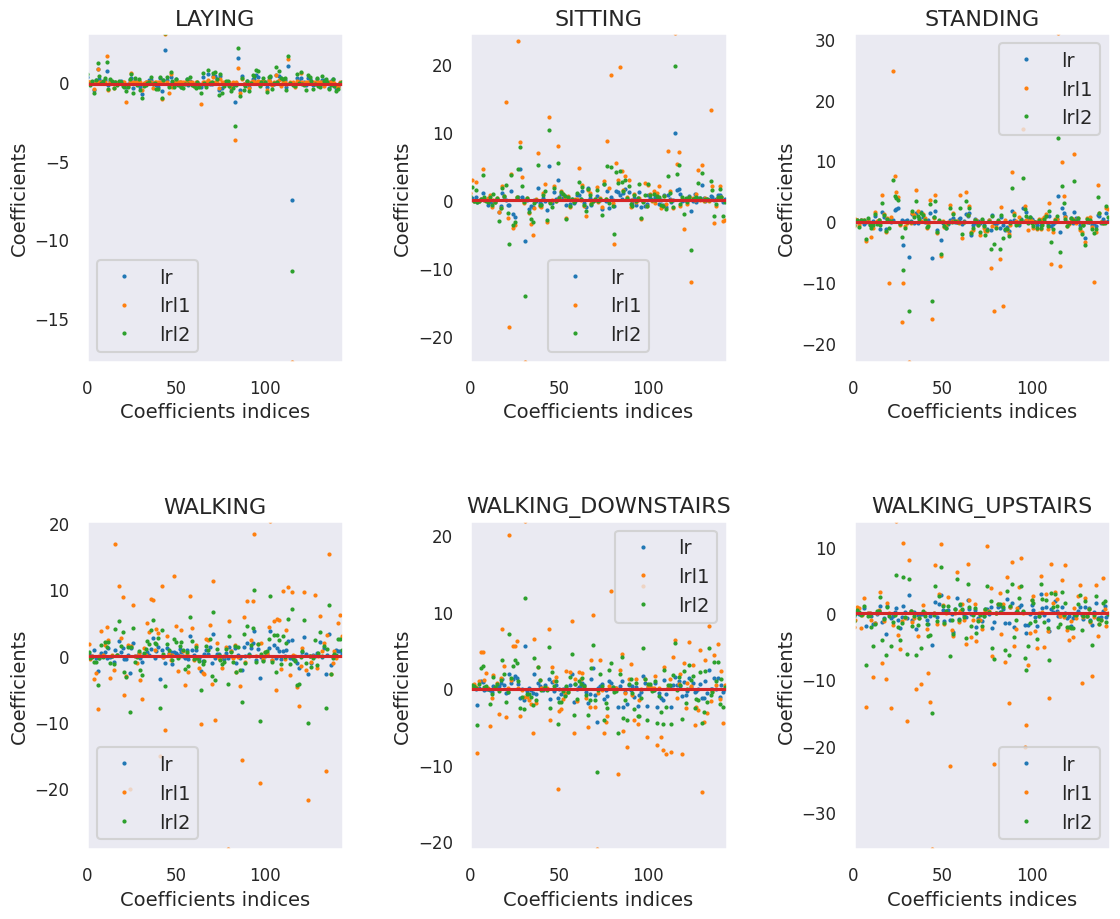

In [ ]:
plt.figure(figsize=(12,10))

k=1
for i in data['target_classes_dictionary'].values():
  plt.subplot(2,3,k)
  x=all_model_coefs.xs(level=1, axis=1,key=i)
  max_ = x.max().max()
  min_ = x.min().min()
  plt.plot(x,'.', markersize=4)
  mean_ = all_model_coefs.xs(level=1, axis=1,key='LAYING').mean().mean()
  mean_line = pd.Series(mean_*np.ones(len(x)))
  plt.plot(mean_line)
  plt.ylim(min_,max_)
  plt.xlim(0,len(all_model_coefs))
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.ylabel('Coefficients' , fontsize=14)
  plt.xlabel('Coefficients indices' , fontsize=14)
  plt.title(f'{i}', fontsize=16)
  plt.legend(loaded_models.keys(), fontsize=14)
  k+=1

plt.tight_layout(h_pad=3, pad = 2)
plt.show()

### **Models evaluations and comparison**

In [ ]:
for cm,model in zip([lr_cm,lrl1_cm, lrl2_cm],['lr', 'lrl1', 'lrl2']):
  TP = [cm.iloc[i,i] for i in range(cm.shape[0])]
  P = [sum(cm.iloc[:,i]) for i in range(cm.shape[0])]

  precision_micro=sum(TP)/sum(P)
  precision_micro=round(precision_micro*100,2)
  print(f'{model} precision micro = {precision_micro}')

lr precision micro = 97.18
lrl1 precision micro = 97.41
lrl2 precision micro = 97.7


#### **Confusion matrix**

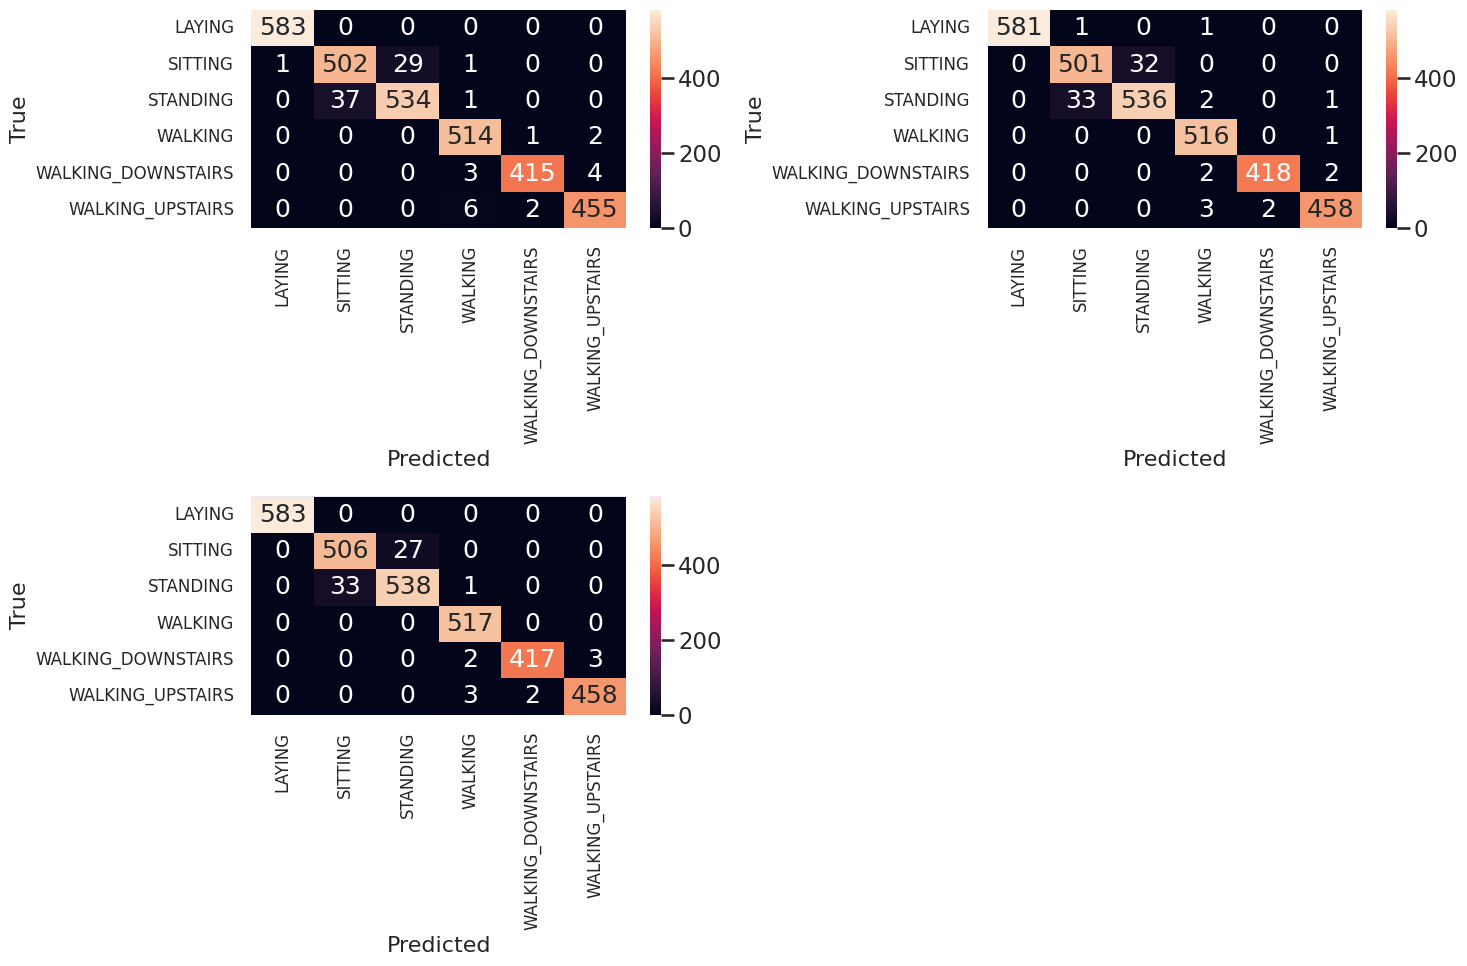

In [ ]:
plt.figure(figsize = (15,10))

k=1
for cm in [lr_cm,lrl1_cm, lrl2_cm]:
  plt.subplot(2,2,k)
  confusion_matrix_visualization(cm, data['target_classes_dictionary'].values())
  k += 1

plt.tight_layout()
plt.show()

Precision_micro calculates precision for each class individually and take the average of precision values for all classes.

In [ ]:
score_table = pd.concat([lr_model_scores,lrl1_model_scores, lrl2_model_scores], axis=0)
score_table.index = ['lr', 'lrl1', 'lrl2']
score_table

,Accuracy,Precision,Recall,F_score,AUC
lr,0.971845,0.971865,0.971845,0.971825,0.982965
lrl1,0.974110,0.974107,0.974110,0.974097,0.984307
lrl2,0.977023,0.977047,0.977023,0.977015,0.986074


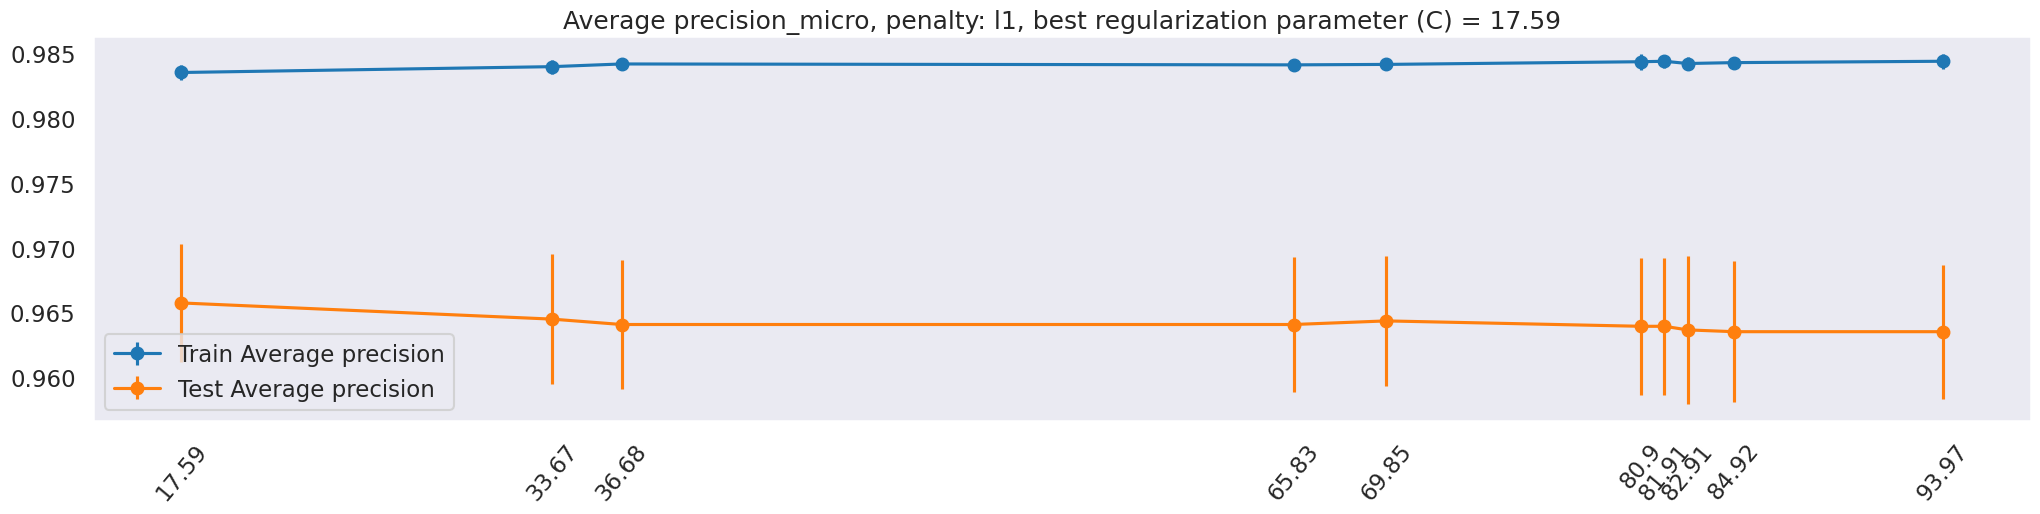

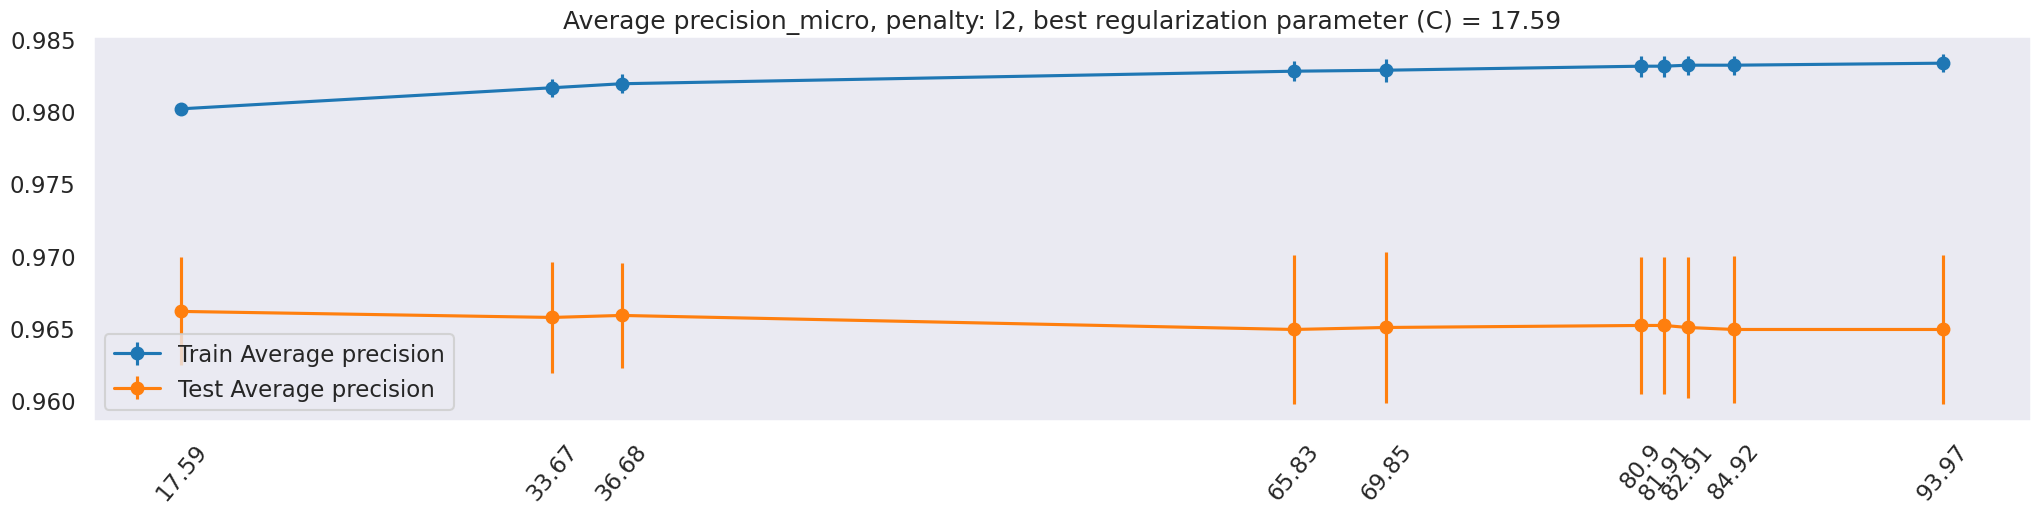

In [ ]:
param_c_scores = scor_calculator(lrl1)
param_c_scores = scor_calculator(lrl2)